# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

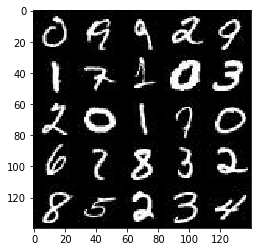

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import pickle as pkl
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

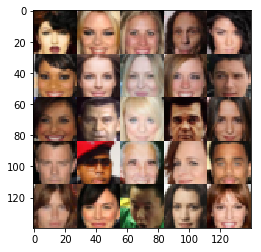

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype=tf.float32, 
                                 shape=(None, image_width, image_height, image_channels),
                                 name='real_images')
    
    z_input = tf.placeholder(dtype=tf.float32,
                             shape=(None, z_dim),
                             name='z_input')
    
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    drop_prob = tf.placeholder(dtype=tf.float32, name='drop_prob')

    return real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate=0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Starts 28x28x3
        x1 = tf.layers.conv2d(images, filters=64,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME',
                             )
        # Now 14x14x64
        a1 = tf.maximum(x1, alpha*x1)
        d1 = tf.layers.dropout(a1,rate=drop_rate)
        
        x2 = tf.layers.conv2d(d1, filters=128,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 7x7x128
        bn1 = tf.layers.batch_normalization(x2, training=True)
        a2 = tf.maximum(bn1, alpha*bn1)
        d2 = tf.layers.dropout(a2, rate=drop_rate)
        
        x3 = tf.layers.conv2d(d2, filters=256,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 4x4x256
        bn2 = tf.layers.batch_normalization(x3, training=True)
        a3 = tf.maximum(bn2, alpha*bn2)
        
        d3 = tf.layers.dropout(a3, rate=drop_rate)
        
        x4 = tf.reshape(d3, shape=(-1, 4*4*256))
        # Now size = [batch_size, 4096 = 4*4*256]
        
        logits = tf.layers.dense(inputs=x4, units=1)
        
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha =0.1
    with tf.variable_scope('generator', reuse= not is_train):
        fc1 = tf.layers.dense(z, units=4*4*512)
        x1 = tf.reshape(fc1, shape=(-1,4,4,512))
        # Shape is 4x4x512
        cn1 = tf.layers.conv2d_transpose(x1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=256,
                                         kernel_size=(4,4),
                                         strides=(1,1),
                                         padding='valid')
        # Shape should be 7x7x256
        #print(cn1.shape)
        bn1 = tf.layers.batch_normalization(cn1, training=is_train)
        a1 = tf.maximum(bn1, alpha*bn1)
        
        cn2 = tf.layers.conv2d_transpose(a1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=128,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #shape 14x14x128
        #print(cn2.shape)
        bn2 = tf.layers.batch_normalization(cn2, training=is_train)
        a2 = tf.maximum(bn2, bn2*alpha)
        
        cn3 = tf.layers.conv2d_transpose(a2,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=out_channel_dim,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #shape 28x28xout_channel_dim
        #print(cn3.shape)
        output = 0.5*tf.tanh(cn3)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_real_outputs, d_real_logits = discriminator(input_real, reuse=False)
    g_outputs = generator(input_z, out_channel_dim, is_train=True)
    d_fake_outputs, d_fake_logits = discriminator(g_outputs, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_real_logits,
        labels=tf.ones_like(d_real_logits)*0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.zeros_like(d_fake_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.ones_like(d_fake_logits)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return images_grid

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    real_images, z_inputs, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    #the numbers for model inputs are determined by the data
    if data_image_mode is "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    d_loss, g_loss = model_loss(real_images, z_inputs, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                z_data = np.random.uniform(low=-0.5,
                                           high=0.5,
                                           size=(batch_size, z_dim))
                
                _ =sess.run(d_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                _ =sess.run(g_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                if steps%25==0:
                    train_loss_d = d_loss.eval({z_inputs: z_data, real_images: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: z_data})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps%100==0:
                    samples.append(show_generator_output(sess, 25, z_inputs, out_channel_dim, data_image_mode))
                    saver.save(sess, './checkpoints/generator.ckpt',global_step=steps)
                    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3564... Generator Loss: 3.6153
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 1.0928


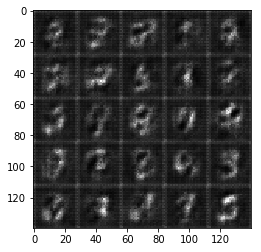

Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.9549
Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 1.9891


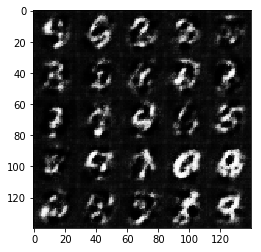

Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 3.3145
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 1.6048


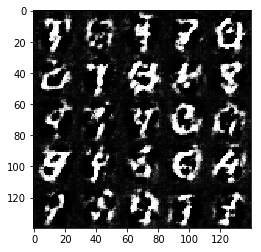

Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 2.4229
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 0.9290
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 1.3459


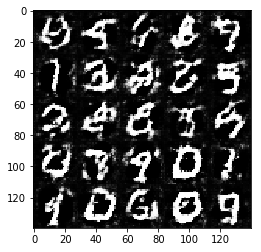

Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 1.2458
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 2.7589
Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 1.7542
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.8312


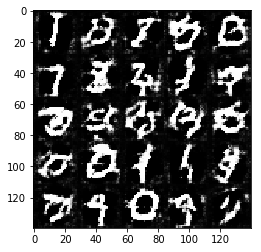

Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 2.4793
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.3964
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 1.8472
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.6248


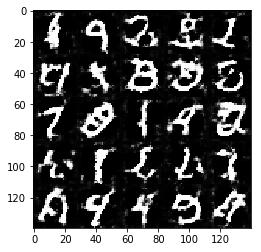

Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 1.2415
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.3015
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.1660


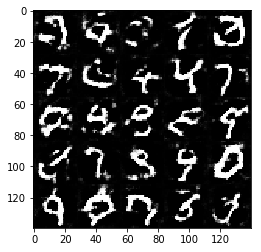

Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.1576
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.6509
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 2.1147


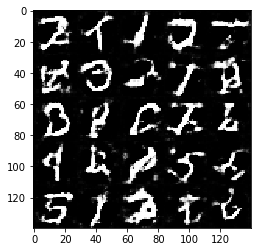

Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 1.0821
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 0.8428... Generator Loss: 1.1306


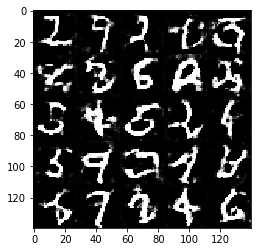

Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 1.6413
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 3.2044
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.9279


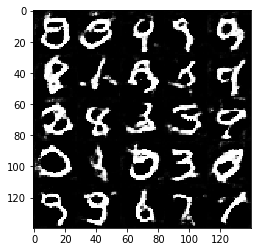

Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 0.6513... Generator Loss: 1.8938
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.2761
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.8088


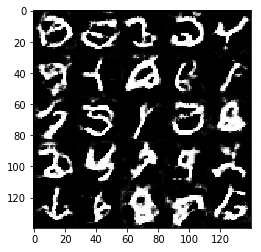

Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 2.2883
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 0.8077


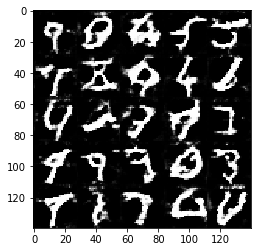

Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.5096
Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 1.7167
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 1.3981


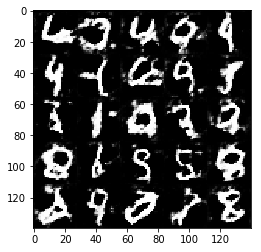

Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.2968


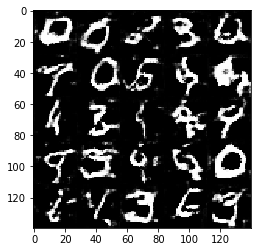

Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 1.4987
Epoch 1/2... Discriminator Loss: 3.0647... Generator Loss: 0.1143
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.3073


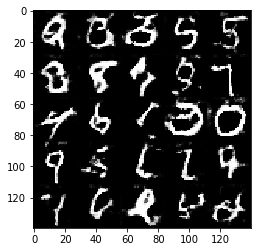

Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 1.4906
Epoch 1/2... Discriminator Loss: 0.6161... Generator Loss: 1.8378
Epoch 1/2... Discriminator Loss: 0.7022... Generator Loss: 1.5071
Epoch 1/2... Discriminator Loss: 0.8332... Generator Loss: 1.0821


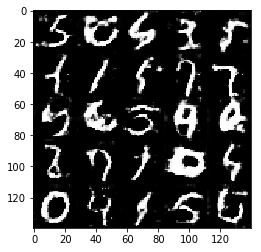

Epoch 1/2... Discriminator Loss: 0.7488... Generator Loss: 1.3562
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 1.4157
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.6117


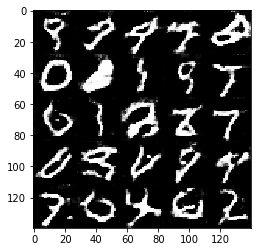

Epoch 1/2... Discriminator Loss: 0.6653... Generator Loss: 1.4636
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 1.9531
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 2.4593
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.5530


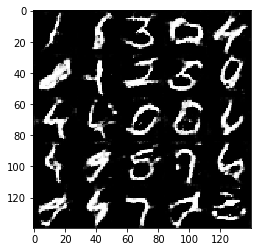

Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 1.4884
Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 1.7562
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 2.0290


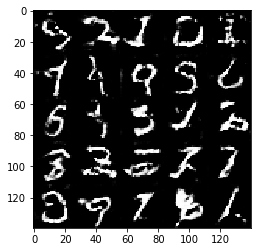

Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.8519
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 3.1008


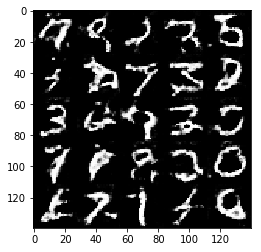

Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.2017
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.2198
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.6440
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.2427


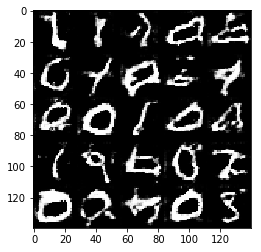

Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.1636
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.3760


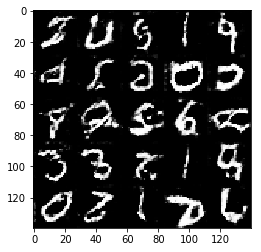

Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.6060
Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 2.1648


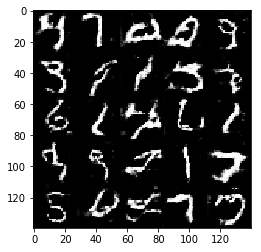

Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 2.0705
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.0531


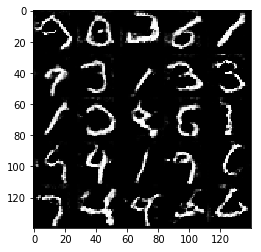

Epoch 2/2... Discriminator Loss: 0.4910... Generator Loss: 2.3242
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.9215
Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.0622


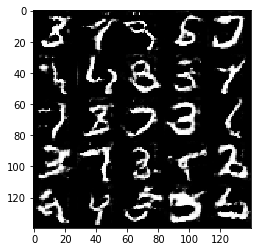

Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 1.8408
Epoch 2/2... Discriminator Loss: 0.6955... Generator Loss: 1.3411
Epoch 2/2... Discriminator Loss: 0.7571... Generator Loss: 2.1275
Epoch 2/2... Discriminator Loss: 0.8720... Generator Loss: 1.1646


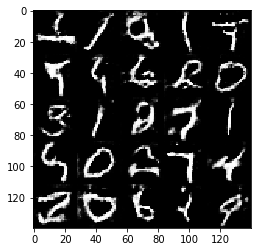

Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 1.8627
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.9638
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 2.2627


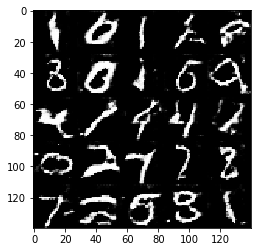

Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 1.9431
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 1.7753
Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 2.1236
Epoch 2/2... Discriminator Loss: 0.5214... Generator Loss: 2.8968


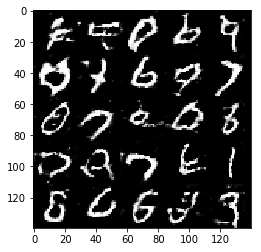

Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 0.6330... Generator Loss: 1.6231
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 1.2769
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 1.7340


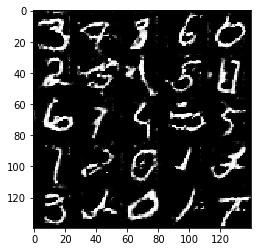

Epoch 2/2... Discriminator Loss: 0.6675... Generator Loss: 1.5257
Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 2.0231
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 2.1455
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.4419


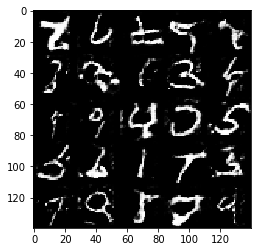

Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.1001
Epoch 2/2... Discriminator Loss: 0.5830... Generator Loss: 1.9640
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.8622


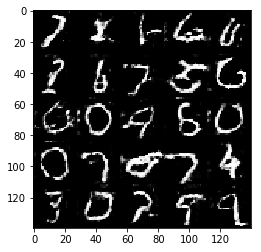

Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.2934
Epoch 2/2... Discriminator Loss: 0.6456... Generator Loss: 1.7690
Epoch 2/2... Discriminator Loss: 0.6174... Generator Loss: 2.1631
Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 1.2254


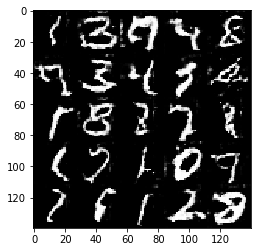

Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 2.0919
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 2.0260
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.2285


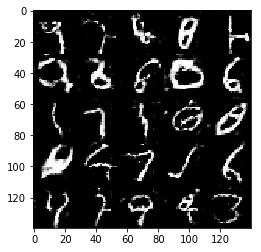

Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 2.2000
Epoch 2/2... Discriminator Loss: 0.5291... Generator Loss: 2.2774
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 1.0380
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.8452


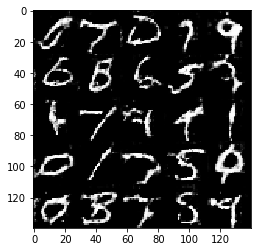

Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 1.6320
Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 1.8054
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.6423
Epoch 2/2... Discriminator Loss: 0.5128... Generator Loss: 2.0863


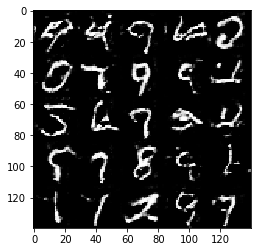

Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 2.1373
Epoch 2/2... Discriminator Loss: 0.5452... Generator Loss: 1.8891
Epoch 2/2... Discriminator Loss: 0.6142... Generator Loss: 1.8435
Epoch 2/2... Discriminator Loss: 0.6191... Generator Loss: 1.7202


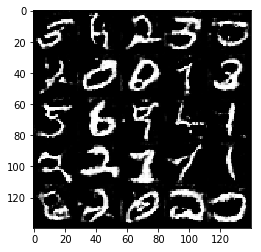

Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 3.0745
Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 1.8819
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.5942
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 3.4206


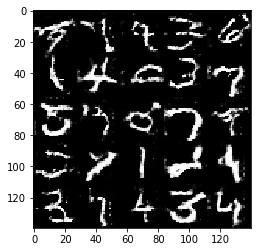

Epoch 2/2... Discriminator Loss: 0.5467... Generator Loss: 2.1630
Epoch 2/2... Discriminator Loss: 0.5247... Generator Loss: 2.0720


In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 3.4058
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.4126
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.7968


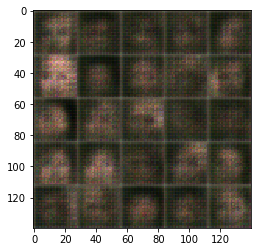

Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 2.4976
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.3604
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6406


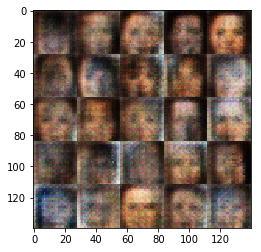

Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.7748
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 0.4116


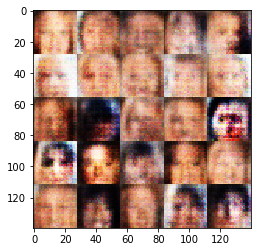

Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.4974


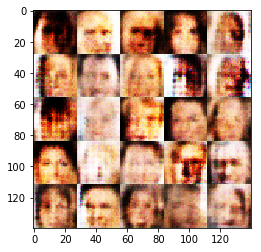

Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8003


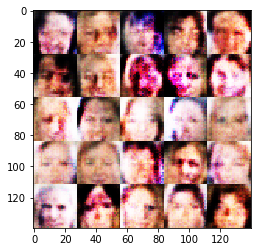

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 1.1287


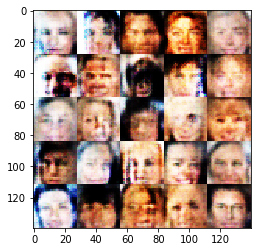

Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7028


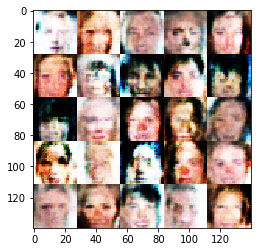

Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.8331


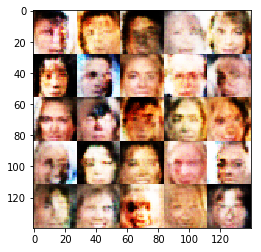

Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.2643


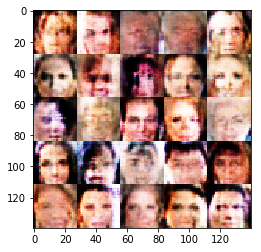

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 1.1923


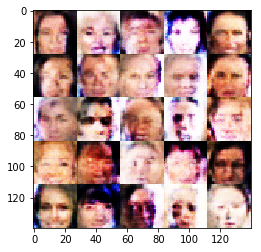

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.5382


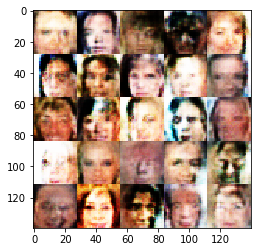

Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.5982


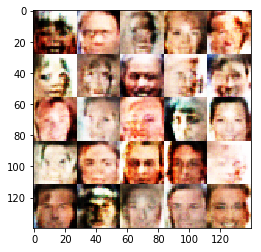

Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.9220


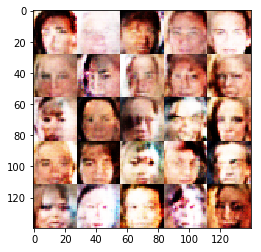

Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.6625
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.1415


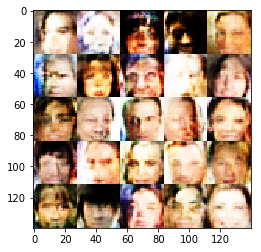

Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.8438
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.0684


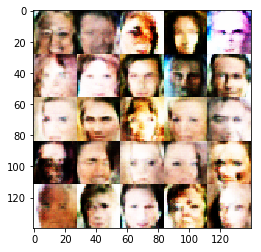

Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.1683


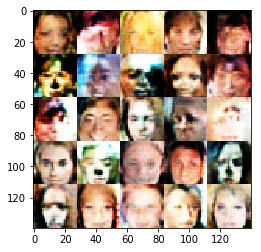

Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 2.2374
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.7311


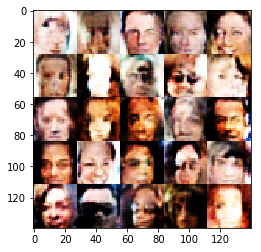

Epoch 1/1... Discriminator Loss: 2.0100... Generator Loss: 0.2502
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.4488
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.8734


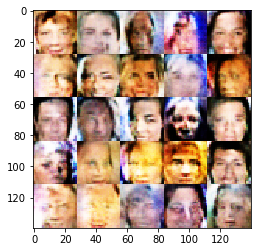

Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.4019
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 1.6365
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 1.7380


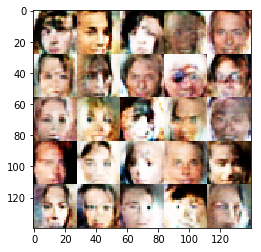

Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 2.1042
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 2.5097
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.4308


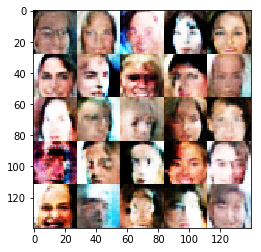

Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.8125
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.8208
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.7394


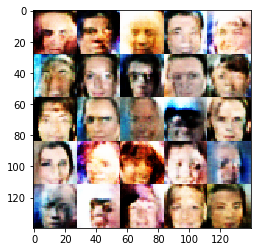

Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.5023
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.5830


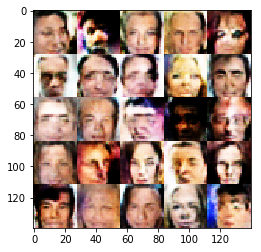

Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.4847
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 2.8035
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 3.3347


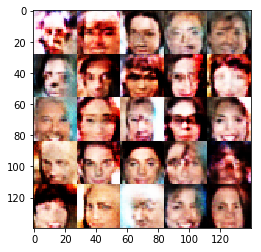

Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 2.1866
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 3.2461
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 1.5689


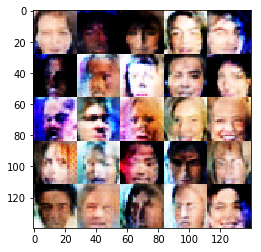

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 1.9501


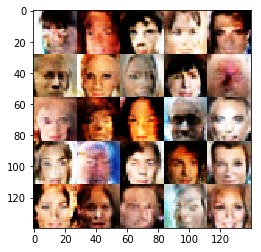

Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.9065
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 3.4405
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.0012


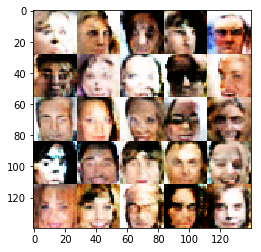

Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 2.4819


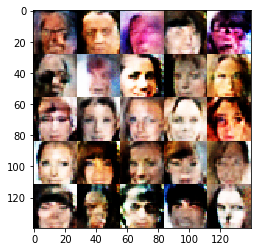

Epoch 1/1... Discriminator Loss: 1.8660... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.8100


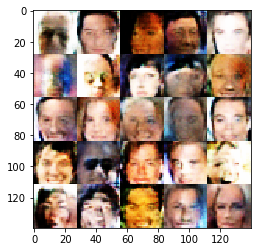

Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 1.9580
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.7076


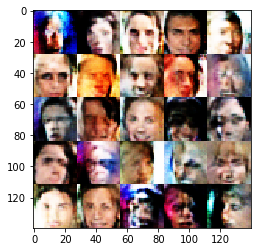

Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.6830
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8103


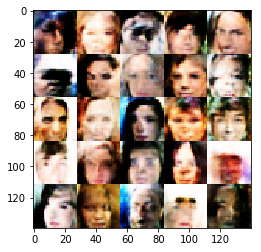

Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.5948
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.1155


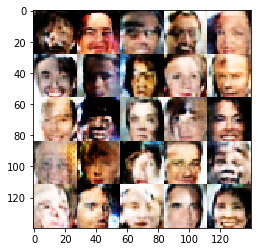

Epoch 1/1... Discriminator Loss: 1.8255... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 3.0507
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.5053


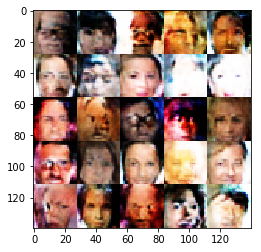

Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 2.0932
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 4.4155
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 3.3845


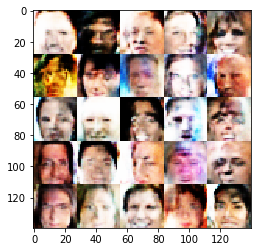

Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.4987


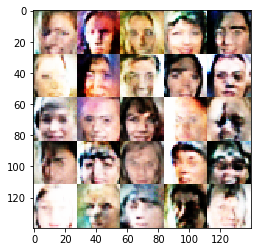

Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 2.1690
Epoch 1/1... Discriminator Loss: 1.7805... Generator Loss: 0.3071
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 4.0838


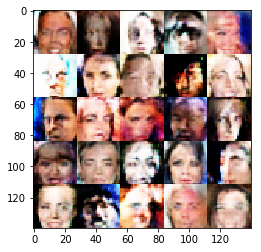

Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 2.1031
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.9469


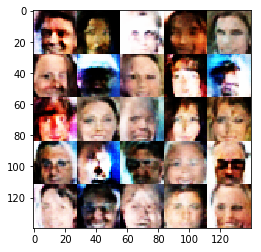

Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.6170


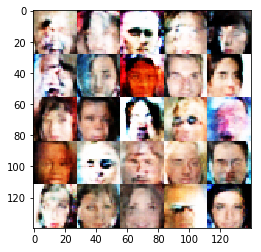

Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.4333


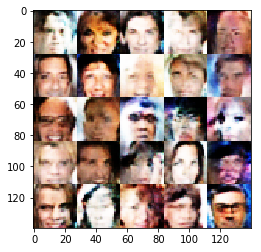

Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.0100
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.2517


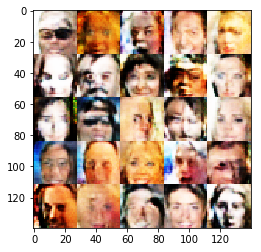

Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 2.5597
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 2.8256
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.0628


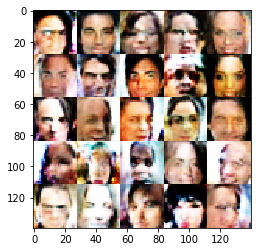

Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6760


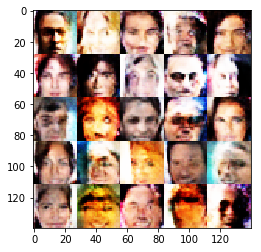

Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.1192
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.7970
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 2.1640
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 2.9002


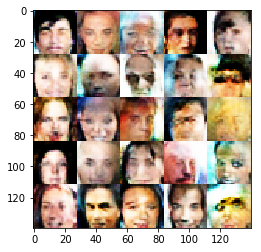

Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.9163
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.2559


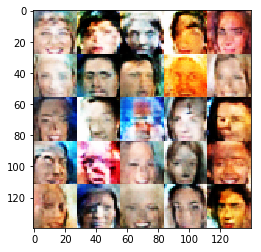

Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 0.4465


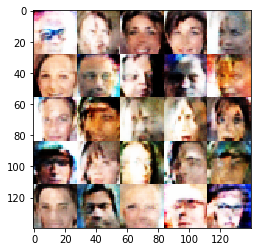

Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.0761


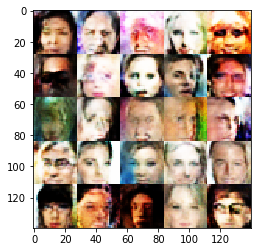

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.7903
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.5477


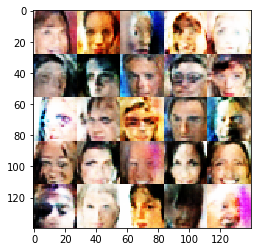

Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 2.1321
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.9049


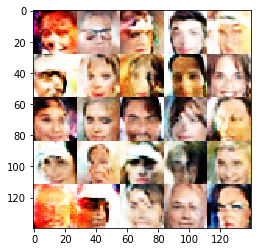

Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 1.9912
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 2.0059
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.8461
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.3479


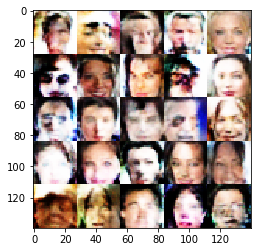

Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6972


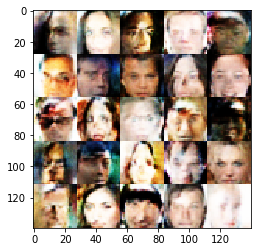

Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 2.1200
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.8255


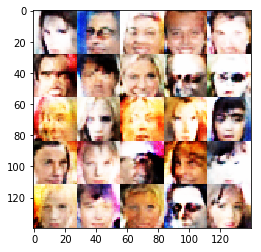

Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.8883
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.3474


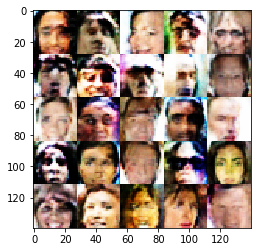

Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.5050
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.5145


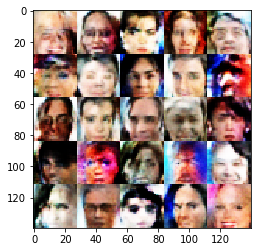

Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.7757... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9432


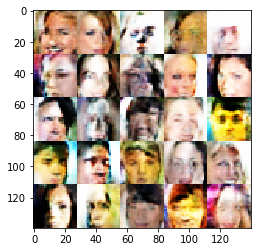

Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.6109


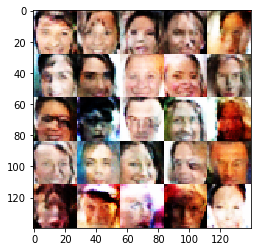

Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.5508
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 2.0088
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.2346


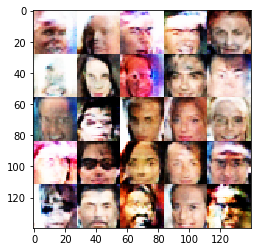

Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.6302
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.5921


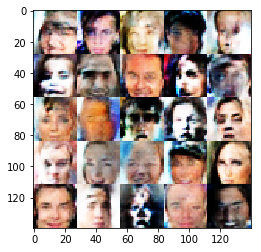

Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 1.8252
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 2.4748
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.8530


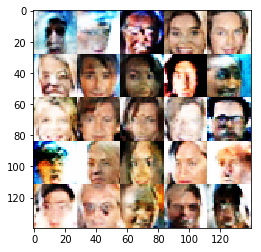

Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.7402


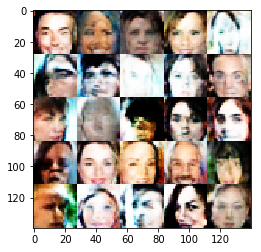

Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.9337


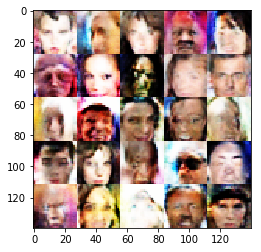

Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.9244


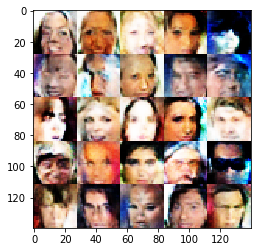

Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.7013
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.7768


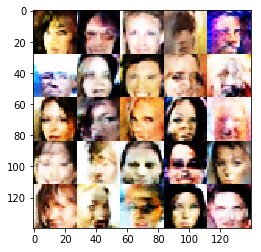

Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.6400
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 2.0616


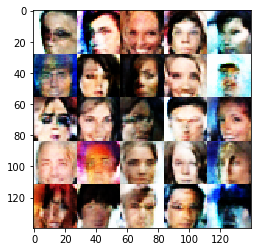

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.5625


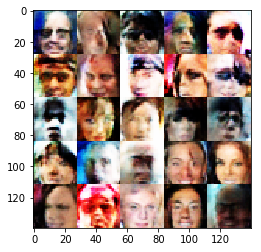

Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0425


In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.